In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sympy import pprint

In [2]:
#INITIALIZE VARIABLES

d1 = 183.3 #joint 1 height [mm]
d2 = 737.31 #joint 2 radius [mm]
d3 = 387.8 #joint 3 radius [mm]
d4 = 95.5 #joint 4 radius [mm]
d5 = 115.5 #joint 5 radius [mm]
d6 = 76.8+45 #end effector offset
q = sp.pi/2 #standard 90 degree angle for ease of coding



In [3]:
#INITIALIZE SYMBOLS
thetai = sp.Symbol('theta_i')
t = sp.Symbol('t')
ai = sp.Symbol('a_i')
di = sp.Symbol('d_i')
alphai = sp.Symbol('alpha_i')
pi = sp.Symbol('pi')

In [4]:
#CREATE DH TABLE ROWS

thetas = sp.symbols('theta_1:7')
dh_theta = [thetas[0], thetas[1]+q, thetas[2], thetas[3]+q, thetas[4], thetas[5]]
dh_a = [0, d2, d3, 0, 0, 0]
dh_d = [d1, 0, 0, d4, d5, d6]
dh_alpha = [q, 0, 0, q, -q, 0]

In [5]:
#CREATE DH TABLE

dh_table = {
    "": ["to 1", "to 2", "to 3", "to 4", "to 5", "to 6"],
    thetai: [dh_theta[0],dh_theta[1],dh_theta[2],dh_theta[3],dh_theta[4],dh_theta[5]],
    ai: [dh_a[0],dh_a[1],dh_a[2],dh_a[3],dh_a[4],dh_a[5]],
    di: [dh_d[0],dh_d[1],dh_d[2],dh_d[3],dh_d[4],dh_d[5]],
    alphai: [dh_alpha[0],dh_alpha[1],dh_alpha[2],dh_alpha[3],dh_alpha[4],dh_alpha[5]]

}

df = pd.DataFrame(dh_table)
df

,,theta_i,a_i,d_i,alpha_i
0,to 1,theta_1,0.00,183.3,pi/2
1,to 2,theta_2 + pi/2,737.31,0.0,0
2,to 3,theta_3,387.80,0.0,0
3,to 4,theta_4 + pi/2,0.00,95.5,pi/2
4,to 5,theta_5,0.00,115.5,-pi/2
5,to 6,theta_6,0.00,121.8,0


In [6]:
#CREATE TRANSFORMATION MATRICES

#Array of all transformation matrices
A_array = [sp.zeros(4,4)]*6
for i in range(0,6):
    A_array[i] = sp.Matrix([
        [sp.cos(dh_theta[i]),-sp.sin(dh_theta[i])*sp.cos(dh_alpha[i]),sp.sin(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.cos(dh_theta[i])],
        [sp.sin(dh_theta[i]),sp.cos(dh_theta[i])*sp.cos(dh_alpha[i]),-sp.cos(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.sin(dh_theta[i])],
        [0,sp.sin(dh_alpha[i]),sp.cos(dh_alpha[i]),dh_d[i]],
        [0,0,0,1]
    ])

#Final transformation matrix A1*A2*A3*A4*A5*A6
A_final = A_array[0]
for i in range(1,6):
    A_final = A_final*A_array[i]

#Array of transformation matrix products [A1, A1*A2, A1*A2*A3,] etc
A_products = [A_array[0]]*6
for i in range(1,6):
    A_products[i] = A_products[i-1]*A_array[i]



In [7]:
#MATRIX SUBSTITUTION FUNCTIONS

#Substitutes theta values into given matrix and returns matrix 
def subs_function(matrix,sub_values):
    result = matrix.subs([
        (thetas[0],sub_values[0]),
        (thetas[1],sub_values[1]),
        (thetas[2],sub_values[2]),
        (thetas[3],sub_values[3]),
        (thetas[4],sub_values[4]),
        (thetas[5],sub_values[5])     
    ])
    return result

#Returns position vector of given transformation matrix and theta values
def subs_position_vector(matrix,sub_values):
    msubs = matrix.subs([
        (thetas[0],sub_values[0]),
        (thetas[1],sub_values[1]),
        (thetas[2],sub_values[2]),
        (thetas[3],sub_values[3]),
        (thetas[4],sub_values[4]),
        (thetas[5],sub_values[5])   
    ])
    result = sp.Matrix([
        [msubs[0,3]],
        [msubs[1,3]],
        [msubs[2,3]],
        [0],
        [0],
        [0]
    ])
    return result


In [8]:


#VALIDATE TRANSFORMATION MATRIX

#5 different sets of theta values for validation
val_matrix = sp.Matrix([
    [0, q, 0, 0, 0],
    [0, 0, q, 0, 0],
    [0, 0, 0, q, 0],
    [0, 0, 0, 0, q],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

#Array of resulting matrices
A_vals = [sp.zeros(4,4)]*5
for i in range(0,5):
    A_vals[i] = subs_function(A_final,val_matrix[:,i])


pos_vals = ["start position","first joint rotated 90 degrees","shoulder rotated 90 degrees","elbow rotated 90 degrees","wrist rotated 90 degrees"]
print("Transformation matrix validation")
for i in range(0,5):
    print("---------------")
    print(pos_vals[i])
    print(
        "x = ",((A_vals[i])[0,3]).round(2),#get x value from matrix i in A_vals array
        "y = ",((A_vals[i])[1,3]).round(2),#get y value from matrix i in A_vals array
        "z = ",((A_vals[i])[2,3]).round(2))#get z value from matrix i in A_vals array




Transformation matrix validation
---------------
start position
x =  0 y =  -217.30 z =  1423.91
---------------
first joint rotated 90 degrees
x =  217.30 y =  0 z =  1423.91
---------------
shoulder rotated 90 degrees
x =  -1240.61 y =  -217.30 z =  183.30
---------------
elbow rotated 90 degrees
x =  -503.30 y =  -217.30 z =  920.61
---------------
wrist rotated 90 degrees
x =  -115.50 y =  -217.30 z =  1308.41


In [9]:
#CREATE JACOBIAN


thetas_vector = sp.Matrix([thetas[0],thetas[1],thetas[2],thetas[3],thetas[4],thetas[5]])

# P = sp.Matrix([A_final[0,3],A_final[1,3],A_final[2,3]])

# Jv = P.jacobian(thetas_vector) #create 3x6 Jv matrix

Z = sp.zeros(3,7) #initialize 3x6 Jw matrix of zeros
Z[:,0] = sp.Matrix([0,0,1])

#replace values in Z with correct values from matrices in A_products array
for c in range(1,7):
    for r in range(0,3):
        Z[r,c] = (A_products[c-1])[r,2]

O = sp.zeros(3,7)
O[:,0] = sp.Matrix([0,0,0])
for c in range(1,7):
    for r in range(0,3):
        O[r,c] = (A_products[c-1])[r,3]


Jv = sp.zeros(3,6) #initialize 6x6 matrix of zeros
for c in range(0,6):
    Jv[:,c] = Z[:,c].cross(O[:,-1]-O[:,c])

#replace values with values from Jv and Jw
J= sp.zeros(6,6)
for c in range(0,6):
    for r in range(0,3):
        J[r,c] = Jv[r,c]
        J[r+3,c] = Z[r,c]






In [10]:
#PATH INPUTS

#initialize inputs
increment = 1 #time increment [s]
duration = 200 #total time [s]
arraysize = int(duration/increment) 
time = np.arange(0, duration, increment) #time array

theta_initial = sp.Matrix([0,3.14/4,3.14/4,0,3.14/4,0]) #Initial theta values (chosen at random)
ee_A_final = subs_position_vector(A_final,theta_initial) #Initial x,y,z position of end effector based on initial theta values

#initial end effector posiitons with respect to base frame [mm]
ee_x_initial = ee_A_final[0] 
ee_y_initial = ee_A_final[1]
ee_z_initial = ee_A_final[2]


#calculate distances traveled during paths
path1_distance = 50*sp.pi
path2_distance = 50
path3_distance = 100
path4_distance = 50
total_distance = path1_distance+path2_distance+path3_distance+path4_distance

#calculate time taken for each path
path1_time = (path1_distance/total_distance)*duration
path2_time = (path2_distance/total_distance)*duration
path3_time = (path3_distance/total_distance)*duration
path4_time = (path4_distance/total_distance)*duration

#calculate start time of each path
path1_start = 0
path2_start = path1_time.round(1)
path3_start = (path2_start+path2_time).round(1)
path4_start = (path3_start+path3_time).round(1)




In [11]:

#VELOCITY PROFILES

#equation for path 1 position with respect to time
path1_x = -(50*sp.cos((sp.pi/path1_time)*t))
path1_y = 0
path1_z = (50*sp.sin((sp.pi/path1_time)*t))

#equation for path 1 velocities with repect to time
path1_xdot = sp.diff(path1_x,t)
path1_ydot = 0
path1_zdot = sp.diff(path1_z,t)

#calculate path 2 velocities
path2_xdot = 0
path2_ydot = 0
path2_zdot = -50/path2_time

#calculate path 3 velocities
path3_xdot = -100/path3_time
path3_ydot = 0
path3_zdot = 0

#calculate path 4 velocities
path4_xdot = 0
path4_ydot = 0
path4_zdot = 50/path4_time

#create xdot master matrix for all paths 
XDOT = sp.Matrix([
    [path1_xdot, path2_xdot, path3_xdot, path4_xdot],
    [path1_ydot, path2_ydot, path3_ydot, path4_ydot],
    [path1_zdot, path2_zdot, path3_zdot, path4_zdot],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]])



In [12]:

#initialize array sizes for each path (for use in for loops)
path1_arraysize = int(path1_time/increment)
path2_arraysize = int(path2_time/increment)
path3_arraysize = int(path3_time/increment)
path4_arraysize = int(path4_time/increment)




In [13]:
#calculate initial inverse jacobian to obtain initial thetadot values


j_initial = (subs_function(J,theta_initial)) #initial  jacobian

if j_initial.det()<0.001:

    jinv_initial = j_initial.pinv()
else:
    jinv_initial = j_initial.inv()

thetadot_initial = jinv_initial*((XDOT[:,0]).subs([(t,0)])) #initial thetadot values















In [14]:
#CALCULATE ANGULAR POSITIONS AND SPEEDS

#Create theta and thetadot arrays and populate with initial values
THETA = sp.zeros(6,arraysize)
THETA[:,0] = theta_initial
THETADOT = sp.zeros(6,arraysize)
THETADOT[:,0] = thetadot_initial

#Fill theta and thetadot arrays
for c in range(1,arraysize):
    t_var = time[c]
    for r in range(0,6):
        THETA[r,c] = (THETA[r,c-1]+((THETADOT[r,c-1])*increment)).round(10)#rounded to speed up program run time
    JSUBS = subs_function(J,THETA[:,c])

    if JSUBS.det()<0.0001:
        jinv = JSUBS.pinv()
    else:
        jinv = JSUBS.inv()
    
    if t_var < path2_start:
        thetadot_temp = jinv*((XDOT[:,0]).subs([(t, t_var)]))
    elif path2_start <= t_var < path3_start:
        thetadot_temp = jinv*XDOT[:,1]
    elif path3_start <= t_var < path4_start:
        thetadot_temp = jinv*XDOT[:,2]
    else:
        thetadot_temp = jinv*XDOT[:,3]

    for r in range(0,6):
        THETADOT[r,c] = thetadot_temp[r]

    

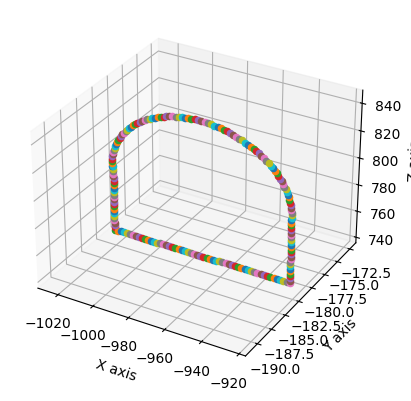

Matrix([
[-1024.38056, -1024.37644, -1024.30884, -1024.17784, -1023.98358, -1023.72632, -1023.40637, -1023.02412, -1022.58005, -1022.0747, -1021.50871, -1020.88277, -1020.19766, -1019.45423, -1018.65342, -1017.79621, -1016.88369, -1015.91698, -1014.89729, -1013.82591, -1012.70418, -1011.5335, -1010.31534, -1009.05124, -1007.74278, -1006.39162, -1004.99946, -1003.56805, -1002.0992, -1000.59478, -999.05669, -997.48688, -995.88733, -994.26008,  -992.6072, -990.93078, -989.23296, -987.51591, -985.78179, -984.03284, -982.27126, -980.49932, -978.71926, -976.93336,  -975.1439, -973.35317, -971.56344,   -969.777, -967.99613, -966.22312, -964.46021, -962.70966, -960.97371, -959.25458, -957.55446, -955.87551, -954.21989, -952.58971, -950.98704, -949.41394, -947.87242, -946.36443, -944.89191, -943.45674, -942.06074,  -940.7057, -939.39334, -938.12534, -936.90332, -935.72884, -934.60339,  -933.5284, -932.50525, -931.53524, -930.61961, -929.75952, -928.95607, -928.21028,  -927.5231,  -926.8954, -92

In [ ]:
#PLOTTING END EFFECTOR POSITION
end_effector_xyz = sp.zeros(3,arraysize)#initialize matrix of xyz positions 

#sub theta array values into final transformation matrix to get end effector xyz values
for c in range(0,arraysize):
    Asubs = subs_function(A_final,THETA[:,c])
    end_effector_xyz[0,c] = (Asubs[0,3]).round(5)
    end_effector_xyz[1,c] = (Asubs[1,3]).round(5)
    end_effector_xyz[2,c] = (Asubs[2,3]).round(5)



#PLOT END EFFECTOR PATH
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,arraysize):
    
    ax.scatter([end_effector_xyz[0,i]], [end_effector_xyz[1,i]], [end_effector_xyz[2,i]])


# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


# Show plot
plt.show()

pprint(end_effector_xyz)


In [16]:
#Rough estimate of weight of each link
m = 11 #robot mass is 11 kg

#lengths of the 8 cylinders
c1 = 173.3
c2 = 172.3
c3 = 737.31
c4 = 172.3
c5 = 387.8
c6 = 95.5
c7 = 115.5
c8 = 76.8
cpen = 45
mpl = m/(c1+c2+c3+c4+c5+c6+c7+c8) #mass per unit length of cylinder

#weights of each link
link1mass = mpl*c1
link2mass = mpl*(c2+c3)
link3mass = mpl*(c4+c5)
link4mass = mpl*c6
link5mass = mpl*c7
link6mass = mpl*c8

#DH table parameters with same orientation as before, but origins at centers of mass
dh_theta = [thetas[0], thetas[1]+q, thetas[2], thetas[3]+q, thetas[4], thetas[5]]
dh_a = [0, 392.08, 570.4, 249.13, 47.75, 57.75]
dh_d = [c1/2, 156.12, -129.44, 21.07, 57.75, 38.40+45]
dh_alpha = [q, 0, 0, q, -q, 0]

#create DH table
dh_table = {
    "": ["to 1", "to 2", "to 3", "to 4", "to 5", "to 6"],
    thetai: [dh_theta[0],dh_theta[1],dh_theta[2],dh_theta[3],dh_theta[4],dh_theta[5]],
    ai: [dh_a[0],dh_a[1],dh_a[2],dh_a[3],dh_a[4],dh_a[5]],
    di: [dh_d[0],dh_d[1],dh_d[2],dh_d[3],dh_d[4],dh_d[5]],
    alphai: [dh_alpha[0],dh_alpha[1],dh_alpha[2],dh_alpha[3],dh_alpha[4],dh_alpha[5]]

}

df = pd.DataFrame(dh_table)
df











,,theta_i,a_i,d_i,alpha_i
0,to 1,theta_1,0.00,86.65,pi/2
1,to 2,theta_2 + pi/2,392.08,156.12,0
2,to 3,theta_3,570.40,-129.44,0
3,to 4,theta_4 + pi/2,249.13,21.07,pi/2
4,to 5,theta_5,47.75,57.75,-pi/2
5,to 6,theta_6,57.75,83.40,0


In [17]:
#Array of transformation matrices for centers of mass
A_array_com = [sp.zeros(4,4)]*6
for i in range(0,6):
    A_array_com[i] = sp.Matrix([
        [sp.cos(dh_theta[i]),-sp.sin(dh_theta[i])*sp.cos(dh_alpha[i]),sp.sin(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.cos(dh_theta[i])],
        [sp.sin(dh_theta[i]),sp.cos(dh_theta[i])*sp.cos(dh_alpha[i]),-sp.cos(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.sin(dh_theta[i])],
        [0,sp.sin(dh_alpha[i]),sp.cos(dh_alpha[i]),dh_d[i]],
        [0,0,0,1]
    ])

#Final COM transformation matrix A1*A2*A3*A4*A5*A6
A_final_com = A_array_com[0]
for i in range(1,6):
    A_final_com = A_final_com*A_array_com[i]

#Array of COM transformation matrix products [A1, A1*A2, A1*A2*A3,] etc
A_products_com = [A_array_com[0]]*6
for i in range(1,6):
    A_products_com[i] = A_products_com[i-1]*A_array_com[i]

In [ ]:
#X,Y,Z position equations of each COM
cm_positions = sp.zeros(3,6)
for c in range(0,6):
    for r in range(0,3):
        cm_positions[r,c] = (A_products_com[c][r,3])*0.001 #converting to meters





Matrix([
[      0,  0.15612*sin(theta_1) - 0.39208*sin(theta_2)*cos(theta_1),  0.02668*sin(theta_1) - 0.5704*sin(theta_2)*cos(theta_1)*cos(theta_3) - 0.39208*sin(theta_2)*cos(theta_1) - 0.5704*sin(theta_3)*cos(theta_1)*cos(theta_2), 0.24913*(sin(theta_2)*sin(theta_3)*cos(theta_1) - cos(theta_1)*cos(theta_2)*cos(theta_3))*cos(theta_4) - 0.24913*(-sin(theta_2)*cos(theta_1)*cos(theta_3) - sin(theta_3)*cos(theta_1)*cos(theta_2))*sin(theta_4) + 0.04775*sin(theta_1) - 0.5704*sin(theta_2)*cos(theta_1)*cos(theta_3) - 0.39208*sin(theta_2)*cos(theta_1) - 0.5704*sin(theta_3)*cos(theta_1)*cos(theta_2), 0.04775*((sin(theta_2)*sin(theta_3)*cos(theta_1) - cos(theta_1)*cos(theta_2)*cos(theta_3))*cos(theta_4) - (-sin(theta_2)*cos(theta_1)*cos(theta_3) - sin(theta_3)*cos(theta_1)*cos(theta_2))*sin(theta_4))*cos(theta_5) + 0.05775*(sin(theta_2)*sin(theta_3)*cos(theta_1) - cos(theta_1)*cos(theta_2)*cos(theta_3))*sin(theta_4) + 0.24913*(sin(theta_2)*sin(theta_3)*cos(theta_1) - cos(theta_1)*cos(theta_2)*cos

In [ ]:

#Potential energy equation as a function of thetas 1-6
PE = 9.81*(
    (link1mass*cm_positions[2,0])+
    (link2mass*cm_positions[2,1])+
    (link3mass*cm_positions[2,2])+
    (link4mass*cm_positions[2,3])+
    (link5mass*cm_positions[2,4])+
    (link6mass*cm_positions[2,5]))


#g vector is partial derivative of PE with respect to thetas 1-6
g = sp.zeros(6,1)
for i in range(0,6):
    g[i] = sp.diff(PE,thetas[i])

#PRINT PARAMETRIC GRAVITY MATRIX
pprint(g)














⎡                                                                              ↪
⎢                                                                              ↪
⎢0.247876503643549⋅(-(sin(θ₂)⋅sin(θ₃) - cos(θ₂)⋅cos(θ₃))⋅sin(θ₄) - (-sin(θ₂)⋅c ↪
⎢                                                                              ↪
⎢             0.247876503643549⋅(-(sin(θ₂)⋅sin(θ₃) - cos(θ₂)⋅cos(θ₃))⋅sin(θ₄)  ↪
⎢                                                                              ↪
⎢                                            0.247876503643549⋅((-sin(θ₂)⋅sin( ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎣                                                                              ↪

↪                                                                              ↪
↪                          

In [ ]:
#CALCULATE REQUIRED TORQUE (NOT INCLUDING FRICTION FROM PEN)
F = sp.Matrix([0,-5,0,0,0,0])# force vector only considers normal force on pen
JT = J.transpose()#transpose of original jacobian from original DH table
torque = g - ((JT*0.001)*F)#torque equation, 0.001 is to convert original jacobian to meters
torque_array = sp.zeros(6,arraysize)
for c in range(0,arraysize):
    torque_array[:,c] = ((subs_function(torque,THETA[:,c]))).applyfunc(lambda x: round(x,5))

pprint(torque_array)

Matrix([
[  -5.1219,  -5.12188,  -5.12154,  -5.12089,  -5.11992,  -5.11863,  -5.11703,  -5.11512,   -5.1129,  -5.11037,  -5.10754,  -5.10441,  -5.10099,  -5.09727,  -5.09327,  -5.08898,  -5.08442,  -5.07958,  -5.07449,  -5.06913,  -5.06352,  -5.05767,  -5.05158,  -5.04526,  -5.03871,  -5.03196,    -5.025,  -5.01784,   -5.0105,  -5.00297,  -4.99528,  -4.98743,  -4.97944,   -4.9713,  -4.96304,  -4.95465,  -4.94616,  -4.93758,  -4.92891,  -4.92016,  -4.91136,   -4.9025,   -4.8936,  -4.88467, -4.87572,  -4.86677,  -4.85782,  -4.84888,  -4.83998,  -4.83112,   -4.8223,  -4.81355,  -4.80487,  -4.79627,  -4.78777,  -4.77938,   -4.7711,  -4.76295,  -4.75494,  -4.74707,  -4.73936,  -4.73182,  -4.72446,  -4.71728,   -4.7103,  -4.70353,  -4.69697,  -4.69063,  -4.68452,  -4.67864,  -4.67302,  -4.66764,  -4.66253,  -4.65768,   -4.6531,   -4.6488,  -4.64478,  -4.64105,  -4.63762,  -4.63448,  -4.63164,  -4.62911,  -4.62688,  -4.62497,  -4.62337,  -4.62209,  -4.62112,  -4.62047,  -4.62014,  -4.62013,  

In [ ]:
#CALCULATE REQUIRED TORQUE, INCLUDING FRICTION FROM THE PEN
#Find direction of travel for each path by finding unit vectors of xdot,ydot,zdot
PATH_UNIT_VECTORS = sp.zeros(3,4)
for c in range(0,4):
    for r in range(0,3):
        PATH_UNIT_VECTORS[r,c] = XDOT[r,c]/(XDOT[:3,c].norm())

friction_force = 0.3*5 #force from coefficient of friction 0.3 and normal force 5 N

#4 separate force vectors, one for each path, dependent on direction of travel
F_with_friction = sp.zeros(6,4)
for c in range(0,4):
    F_with_friction[0,c] = -friction_force*PATH_UNIT_VECTORS[0,c]
    F_with_friction[1,c] = -5
    F_with_friction[2,c] = -friction_force*PATH_UNIT_VECTORS[2,c]
    F_with_friction[3,c] = 0
    F_with_friction[4,c] = 0
    F_with_friction[5,c] = 0

#Torque equation for each joint for each path
torque_with_friction = sp.zeros(6,4)
for c in range(0,4):
    torque_with_friction[:,c] = g-((JT*0.001)*F_with_friction[:,c])

#Torque array to compensate for link weights, normal force, and friction force
torque_with_friction_array = sp.zeros(6,arraysize)
for c in range(0,arraysize):
    t_var = time[c]
    if t_var < path2_start:
        torque_with_friction_array[:,c] = ((subs_function((torque_with_friction[:,0]).subs([(t,t_var)]),THETA[:,c]))).applyfunc(lambda x: round(x,5))
    elif path2_start <= t_var < path3_start:
        torque_with_friction_array[:,c] = ((subs_function(torque_with_friction[:,1],THETA[:,c]))).applyfunc(lambda x: round(x,2))
    elif path3_start <= t_var < path4_start:
        torque_with_friction_array[:,c] = ((subs_function(torque_with_friction[:,2],THETA[:,c]))).applyfunc(lambda x: round(x,2))
    else:
        torque_with_friction_array[:,c] = ((subs_function(torque_with_friction[:,3],THETA[:,c]))).applyfunc(lambda x: round(x,2))

pprrint(torque_with_friction_array)



Matrix([
[  -5.1219,  -5.11215,   -5.1021,  -5.09175,  -5.08113,  -5.07024,   -5.0591,  -5.04772,  -5.03611,   -5.0243,   -5.0123,  -5.00011,  -4.98777,  -4.97527,  -4.96265,  -4.94991,  -4.93707,  -4.92415,  -4.91116,  -4.89812,  -4.88504,  -4.87195,  -4.85886,  -4.84579,  -4.83275,  -4.81975,  -4.80682,  -4.79398,  -4.78123,   -4.7686,  -4.75609,  -4.74374,  -4.73154,  -4.71952,   -4.7077,  -4.69608,  -4.68469,  -4.67353,  -4.66263,  -4.65199,  -4.64163,  -4.63156,  -4.62179,  -4.61235,  -4.60323,  -4.59445,  -4.58603,  -4.57797,  -4.57028,  -4.56297,  -4.55606,  -4.54955,  -4.54345,  -4.53776,   -4.5325,  -4.52768,  -4.52329,  -4.51934,  -4.51584,  -4.51279,   -4.5102,  -4.50807,   -4.5064,   -4.5052,  -4.50446,  -4.50419,  -4.50439,  -4.50505,  -4.50619,  -4.50778,  -4.50984,  -4.51236,  -4.51534,  -4.51877,  -4.52265,  -4.52697,  -4.53174,  -4.53693,  -4.54255,  -4.54859,  -4.55504,  -4.56189,  -4.56914,  -4.57677,  -4.58477,  -4.59315,  -4.60187,  -4.61094,  -4.62,  -4.62,  -4.62

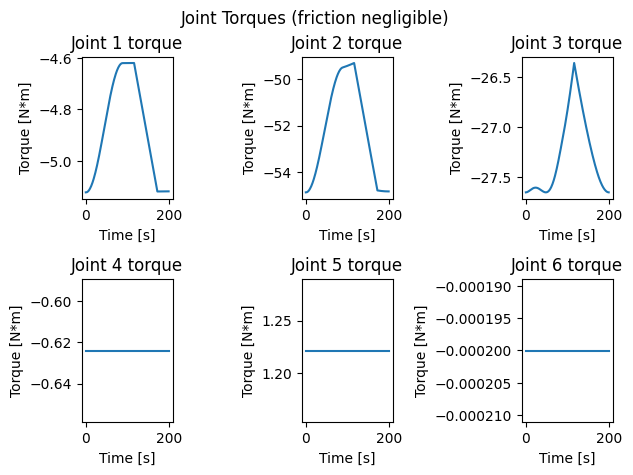

In [34]:
figure, axis = plt.subplots(2,3)

axis[0,0].plot(time, (torque_array[0,:]).transpose())
axis[0,0].set_title("Joint 1 torque")
axis[0,0].set_xlabel("Time [s]")
axis[0,0].set_ylabel("Torque [N*m]")

axis[0,1].plot(time, (torque_array[1,:]).transpose())
axis[0,1].set_title("Joint 2 torque")
axis[0,1].set_xlabel("Time [s]")
axis[0,1].set_ylabel("Torque [N*m]")

axis[0,2].plot(time, (torque_array[2,:]).transpose())
axis[0,2].set_title("Joint 3 torque")
axis[0,2].set_xlabel("Time [s]")
axis[0,2].set_ylabel("Torque [N*m]")

axis[1,0].plot(time, (torque_array[3,:]).transpose())
axis[1,0].set_title("Joint 4 torque")
axis[1,0].set_xlabel("Time [s]")
axis[1,0].set_ylabel("Torque [N*m]")


axis[1,1].plot(time, (torque_array[4,:]).transpose())
axis[1,1].set_title("Joint 5 torque")
axis[1,1].set_xlabel("Time [s]")
axis[1,1].set_ylabel("Torque [N*m]")

axis[1,2].plot(time, (torque_array[5,:]).transpose())
axis[1,2].set_title("Joint 6 torque")
axis[1,2].set_xlabel("Time [s]")
axis[1,2].set_ylabel("Torque [N*m]")


plt.tight_layout(rect=[0,0,1,0.96])
figure.suptitle("Joint Torques (friction negligible)")
plt.show()

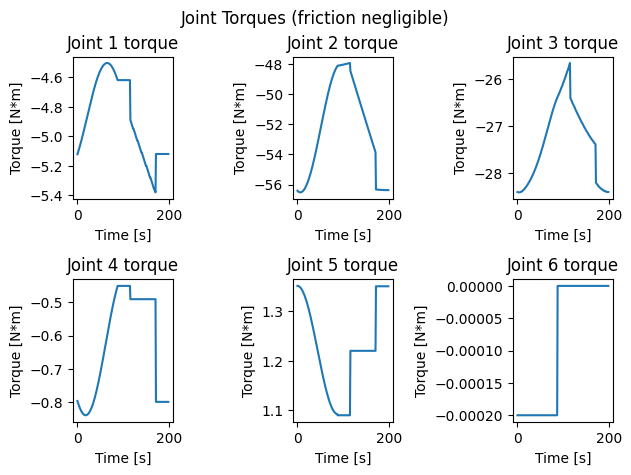

In [36]:
figure, axis = plt.subplots(2,3)

axis[0,0].plot(time, (torque_with_friction_array[0,:]).transpose())
axis[0,0].set_title("Joint 1 torque")
axis[0,0].set_xlabel("Time [s]")
axis[0,0].set_ylabel("Torque [N*m]")

axis[0,1].plot(time, (torque_with_friction_array[1,:]).transpose())
axis[0,1].set_title("Joint 2 torque")
axis[0,1].set_xlabel("Time [s]")
axis[0,1].set_ylabel("Torque [N*m]")

axis[0,2].plot(time, (torque_with_friction_array[2,:]).transpose())
axis[0,2].set_title("Joint 3 torque")
axis[0,2].set_xlabel("Time [s]")
axis[0,2].set_ylabel("Torque [N*m]")

axis[1,0].plot(time, (torque_with_friction_array[3,:]).transpose())
axis[1,0].set_title("Joint 4 torque")
axis[1,0].set_xlabel("Time [s]")
axis[1,0].set_ylabel("Torque [N*m]")


axis[1,1].plot(time, (torque_with_friction_array[4,:]).transpose())
axis[1,1].set_title("Joint 5 torque")
axis[1,1].set_xlabel("Time [s]")
axis[1,1].set_ylabel("Torque [N*m]")

axis[1,2].plot(time, (torque_with_friction_array[5,:]).transpose())
axis[1,2].set_title("Joint 6 torque")
axis[1,2].set_xlabel("Time [s]")
axis[1,2].set_ylabel("Torque [N*m]")


plt.tight_layout(rect=[0,0,1,0.96])
figure.suptitle("Joint Torques (friction negligible)")
plt.show()